In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet, show, loadmap, AggMapNet_DP

In [2]:
#选择哪个GPU进行计算，“2”代表编号为2的GPU
gpu_id = "6"
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [18]:
#Self-definition
file = "Cisplatin" #Carboplatin/Cisplatin/Paclitaxel
cancer = "BLCA" # (UCEC)/pancancer # BLCA/CESC/LUAD/pancancer # (BRCA)
clu_channels = 7
cv = 5
ran_seed = 0

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-response+cancer.csv".format(file), header = 0, index_col = 0)
cv_split = pd.read_csv("/raid/mobu/0_datasets/{}_phenotype.csv".format(file), header = 0, index_col = 0)

if cancer == "pancancer":
    data_T = data_T.drop(columns = "cancer")
else:
    data_T = data_T[data_T["cancer"]==cancer].drop(columns = "cancer")

dataX = data_T.drop(columns = ["response"])
dataY = data_T["response"]

In [3]:
#Data input
file = "CN-AML"
clu_channels = 7
ran_seed = 0

data_T = pd.read_csv("{}_log2expression-response.csv".format(file), header = 0, index_col = 0)

#Feature Matrix and Y_true labels
dataX = data_T.drop(columns = "response")
dataY = data_T["response"]

In [4]:
#将数据集划分为训练集和测试集
import random
tr_size = 0.8
tt_dic = {}

for i, j in data_T.groupby(by = ["response"], axis = 0):
    random.seed(ran_seed)
    j_l = list(j.index)
    tr_ones = random.sample(j_l, round(tr_size*len(j_l)))  #random sampling
    test_ones = j.index[[x not in tr_ones for x in j.index]]
    tt_dic["train_set"] = tt_dic.get("train_set",[]) + tr_ones
    tt_dic["test_set"] = tt_dic.get("test_set",[]) + list(test_ones)

#f_tt = open("/raid/saiki/TT-split/0_Final-Patient_TT-sample-id.txt", "a+")
#f_tt.write("Dataset: {}\nRandom state: {}\nTrain set({}): {}\nTest set({}): {}\n\n".format(file, ran_seed, len(tt_dic["train_set"]), tt_dic["train_set"], len(tt_dic["test_set"]), tt_dic["test_set"]))
#f_tt.close()
#print("Train set: {}\nTest set: {}".format(len(tt_dic["train_set"]), len(tt_dic["test_set"])))

trainX, trainY = dataX.loc[tt_dic["train_set"]], dataY.loc[tt_dic["train_set"]]
testX, testY = dataX.loc[tt_dic["test_set"]], dataY.loc[tt_dic["test_set"]]

In [5]:
len(trainX), len(testX)

(214, 54)

In [5]:
#Self-definition
file = "LNN-BRCA"
ran_seed = 0
#Bortezomib/Bortezomib_PD-R/Cisplatin/Paclitaxel/CN-AML/MBC/KT-1/KT-2/Docetaxel/Infliximab-1/Infliximab-2
#NPC/BRCA_Cisplatin/PARPI/KT-3/RA-PBMC/RA-CD4/RA-CD14

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-ER_Status+time+relapse+response.csv".format(file), header = 0, index_col = 0)

#数据集的预处理，提取出特征集和标签集
data_T = data_T.loc[pd.notnull(data_T["response"])]
dataX = data_T.drop(columns = ["ER_Status","time_to_relapse","relapse_(1=True)","response"])
dataY = data_T["response"]

#将数据集划分为训练集和测试集
import random
tt_dic = {}

for i, j in data_T.groupby(by = ["ER_Status"], axis = 0):
    random.seed(ran_seed)
    j_l = list(j.index)
    if i == "ER+":
        trnum = 75
    else:
        trnum = 30
    tr_ones = random.sample(j_l, trnum)  #random sampling
    test_ones = j.index[[x not in tr_ones for x in j.index]]
    tt_dic["train_set"] = tt_dic.get("train_set",[]) + tr_ones
    tt_dic["test_set"] = tt_dic.get("test_set",[]) + list(test_ones)
    
trainX, trainY = dataX.loc[tt_dic["train_set"]], dataY.loc[tt_dic["train_set"]]
testX, testY = dataX.loc[tt_dic["test_set"]], dataY.loc[tt_dic["test_set"]]

In [33]:
#Self-definition
file = "KT-1"
file_2 = "KT-2"
#KT-1/KT-2/Infliximab-1/Infliximab-2

clu_channels = 7
cv = 5
ran_seed = 0

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-response.csv".format(file), header = 0, index_col = 0) #dtype = np.float32)

#数据集的预处理，提取出特征集和标签集
dataX = data_T.drop(columns = "response")
dataY = data_T["response"]

#feature selection
# MAD_list = stats.median_abs_deviation(dataX, axis = 0, nan_policy = "omit")
# f_sorted = np.argsort(MAD_list)[::-1]
# f_name = dataX.columns[f_sorted]

# dataX_mad = dataX.reindex(columns = f_name[:f_num])
# dataX_mad = pairwise_cal(dataX_mad.astype(np.float32))
# data_T_mad = pd.concat([dataX_mad,dataY], axis = 1)

if file_2:
    data_T_2 = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-response.csv".format(file_2), header = 0, index_col = 0)
    trainX = data_T.drop(columns = "response")
#     trainX_mad = data_T_mad.drop(columns = "response")
    testX = data_T_2.drop(columns = "response")
#     testX_mad = data_T_2.reindex(columns = f_name[:f_num])
#     testX_mad = pairwise_cal(testX_mad)
    trainY = data_T["response"]
    testY = data_T_2["response"]

In [28]:
#Self-definition
file = "LNN-BRCA"
#Bortezomib/Bortezomib_PD-R/Cisplatin/Paclitaxel/CN-AML/MBC/KT-1/KT-2/Docetaxel/Infliximab-1/Infliximab-2
#NPC/BRCA_Cisplatin/PARPI/KT-3/RA-PBMC/RA-CD4/RA-CD14
f_num = 200
clu_channels = 7
cv = 5
ran_seed = 0

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-ER_Status+time+relapse+response.csv".format(file), header = 0, index_col = 0)

#数据集的预处理，提取出特征集和标签集
data_T = data_T.loc[pd.notnull(data_T["response"])]
dataX = data_T.drop(columns = ["ER_Status","time_to_relapse","relapse_(1=True)","response"])
dataY = data_T["response"]

In [5]:
#feature selection
MAD_list = stats.median_abs_deviation(dataX, axis = 0, nan_policy = "omit")
f_sorted = np.argsort(MAD_list)[::-1]
f_name = dataX.columns[f_sorted]

dataX_mad = dataX.reindex(columns = f_name[:f_num])
dataX_mad = pairwise_cal(dataX_mad)
data_T_mad = pd.concat([dataX_mad,data_T[["ER_Status","time_to_relapse","relapse_(1=True)","response"]]], axis = 1)

#将数据集划分为训练集和测试集
import random
tt_dic = {}

for i, j in data_T.groupby(by = ["ER_Status"], axis = 0):
    random.seed(ran_seed)
    j_l = list(j.index)
    if i == "ER+":
        trnum = 75
    else:
        trnum = 30
    tr_ones = random.sample(j_l, trnum)  #random sampling
    test_ones = j.index[[x not in tr_ones for x in j.index]]
    tt_dic["train_set"] = tt_dic.get("train_set",[]) + tr_ones
    tt_dic["test_set"] = tt_dic.get("test_set",[]) + list(test_ones)

#f_tt = open("/raid/saiki/TT-split/0_Final-Patient_TT-sample-id.txt", "a+")
#f_tt.write("Dataset: {}\nRandom state: {}\nTrain set({}): {}\nTest set({}): {}\n\n".format(file, ran_seed, len(tt_dic["train_set"]), tt_dic["train_set"], len(tt_dic["test_set"]), tt_dic["test_set"]))
#f_tt.close()
#print("Train set: {}\nTest set: {}".format(len(tt_dic["train_set"]), len(tt_dic["test_set"])))

trainX, trainY = dataX.loc[tt_dic["train_set"]], dataY.loc[tt_dic["train_set"]]
testX, testY = dataX.loc[tt_dic["test_set"]], dataY.loc[tt_dic["test_set"]]
trainX_mad = dataX_mad.loc[tt_dic["train_set"]]
testX_mad = dataX_mad.loc[tt_dic["test_set"]]

In [4]:
#Self-definition
file = "Bortezomib"
drug = "PS341" #PS341/Dex
data_split = "NR-R_response" #PD-R_response/NR-R_response

clu_channels = 5
cv = 5
ran_seed = 0

#读入数据集
data_T = pd.read_csv("/raid/mobu/0_datasets/{}_log2expression-response+trial+drug.csv".format(file), header = 0, index_col = 0)
dataX = data_T.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])

data_T = data_T[pd.notnull(data_T[data_split])]
train_xy = data_T.loc[[i in [25, 40] for i in data_T["trial"]]]
test_xy = data_T.loc[data_T["trial"] == 39].loc[data_T["drug"] == drug]

trainX = train_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])
testX = test_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])
trainY = train_xy[data_split]
testY = test_xy[data_split]

In [7]:
trainX

A1CF        A2M    A4GALT     A4GNT      AAAS       AACS  \
GSM36911  8.192293  12.106105  6.586465  7.474923  6.899659   9.628446   
GSM37038  8.306062  11.466637  7.233620  7.747522  7.561479   9.944126   
GSM36924  7.710118  11.393712  6.338068  7.052025  8.656425   9.614342   
GSM36792  9.021258  11.602374  7.249825  5.572890  8.084808   9.443358   
GSM36870  8.502633  12.717955  4.452859  7.391458  4.990955  10.330917   
...            ...        ...       ...       ...       ...        ...   
GSM36816  8.332708  13.106301  6.773469  6.944858  4.827819   9.400239   
GSM36865  8.613605  11.682073  6.261155  6.675251  5.048759   9.648178   
GSM37002  8.493455  11.704033  4.614710  7.191800  7.677367   9.763212   
GSM36795  9.035349  11.780007  7.489447  7.849249  8.384136   8.411511   
GSM36876  8.814422  11.585338  6.942515  7.589464  6.309249   9.826707   

             AADAC     AAGAB      AAK1      AAMDC  ...    ZSWIM1    ZSWIM8  \
GSM36911  4.578939  8.798958  8.222070   8.317563  ...  7.511753  8.509379   
GSM37038  4.614710  8.655531  7.826167   8.099085  ...  7.504620  8.681765   
GSM36924  4.608809  9.037959  7.056150   7.841302  ...  7.342519  8.408754   
GSM36792  4.807355  8.658569  8.003377  11.950131  ...  7.820179  8.973984   
GSM36870  4.897240  9.465770  8.045159   8.332260  ...  7.596935  8.793766   
...            ...       ...       ...        ...  ...       ...       ...   
GSM36816  6.910493  7.942808  8.262753   8.126532  ...  7.410239  8.944419   
GSM36865  4.867896  7.476949  7.507795   8.169591  ...  7.246978  8.798634   
GSM37002  4.596935  8.482606  7.092334   8.235855  ...  7.758889  9.574783   
GSM36795  4.185867  7.606220  7.815319   7.444325  ...  7.580447  9.872983   
GSM36876  4.807355  8.451005  7.999775   8.261468  ...  7.921246  9.423116   

              ZW10    ZWILCH      ZWINT      ZXDB      ZXDC        ZYX  \
GSM36911  9.648717  8.061236   9.516685  6.129283  8.824322  10.170614   
GSM37038  9.426894  6.716991  11.462451  5.986411  9.433168  10.233680   
GSM36924  9.553821  8.529821  10.037547  6.501439  9.320801   9.133271   
GSM36792  8.981853  7.641691  11.060020  6.422906  8.564531   9.481497   
GSM36870  9.401733  5.725196  12.305948  3.000000  7.989820   9.209575   
...            ...       ...        ...       ...       ...        ...   
GSM36816  8.785616  7.518063  10.560046  5.255501  8.877438  10.782671   
GSM36865  8.824004  8.665336  11.241209  6.207502  8.116864  11.349585   
GSM37002  9.670479  8.512938  11.005625  6.318317  9.806711   9.964124   
GSM36795  8.643495  7.548437  10.889656  3.776104  8.632632  11.455122   
GSM36876  9.421013  6.285402  10.895651  5.733354  9.184875   9.623607   

             ZZEF1       ZZZ3  
GSM36911  8.293395   9.275892  
GSM37038  7.508059   9.829564  
GSM36924  7.651291   9.917820  
GSM36792  7.937030  10.613513  
GSM36870  7.912291   9.520226  
...            ...        ...  
GSM36816  7.936834   9.857981  
GSM36865  7.337771   9.591148  
GSM37002  7.993221  10.291056  
GSM36795  7.855907   8.812498  
GSM36876  8.408967   9.684573  

[105 rows x 12548 columns]

In [6]:
phe_list = []
ref_phe = pd.read_csv("/raid/saiki/1_new-data/Bortezomib_PD-R_phenotype.csv", header = 0, index_col = 0)
for i in trainX.index:
    phe_list.append(ref_phe.loc[i, "characteristics_ch1.7"][-2:])
phe_list

['NC',
 'NC',
 'PR',
 'NC',
 'PR',
 'MR',
 'NC',
 'PD',
 'NC',
 'PD',
 'PR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PD',
 'PR',
 'PR',
 'CR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'MR',
 'PR',
 'PD',
 'PR',
 'NC',
 'NC',
 'PR',
 'PD',
 'PR',
 'PR',
 'NC',
 'PR',
 'NC',
 'PD',
 'PR',
 'PR',
 'PD',
 'PD',
 'PD',
 'PR',
 'MR',
 'PD',
 'NC',
 'NC',
 'PD',
 'MR',
 'PR',
 'NC',
 'NC',
 'NC',
 'PD',
 'NC',
 'PR',
 'MR',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'NC',
 'NC',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'NC',
 'PD',
 'NC',
 'NC',
 'NC',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'CR',
 'MR',
 'MR',
 'CR',
 'PD',
 'PD',
 'NC',
 'PD']

In [19]:
#feature selection
MAD_list = stats.median_abs_deviation(dataX, axis = 0, nan_policy = "omit")
f_sorted = np.argsort(MAD_list)[::-1]
f_name = dataX.columns[f_sorted]

#trainX_mad = trainX.reindex(columns = f_name[:f_num])
#testX_mad = testX.reindex(columns = f_name[:f_num])
dataX_mad = dataX.reindex(columns = f_name[:f_num])

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = f_num)
dataX_pca = pd.DataFrame(pca.fit_transform(dataX), index = dataX.index)
dataX_pca = pairwise_cal(dataX_pca)
data_pcaT = pd.concat([dataX_pca, data_T[["PD-R_response","NR-R_response","trial","drug"]].copy()], axis = 1)
data_pcaT

0          1          2          3          4          5  \
GSM246523 -25.439196   3.913037  -9.876896 -23.589485 -26.100048 -12.999988   
GSM246524   2.356700  12.436899   4.242622  -8.767957 -12.063993  15.742619   
GSM246525  37.303202  29.444453  18.280498  14.507678   7.544812  26.293282   
GSM246526  36.032698  21.282071  32.395908  10.905962  13.778591  28.829089   
GSM246527 -13.249848  -0.775801  -4.545762  -3.170328  -7.070852 -16.681177   
...              ...        ...        ...        ...        ...        ...   
GSM246782 -30.249789  -8.634674   1.975169  -9.889326 -11.584249 -16.216077   
GSM246783 -39.243248 -17.190547 -20.361817 -12.332717 -22.912261 -19.189877   
GSM246784 -60.515253 -39.927890 -19.662724 -35.914278 -28.052621 -27.616315   
GSM246785  -5.200414 -19.221406  -9.239494   4.058074  -2.597584  -6.749301   
GSM246786 -30.918270 -19.847136 -12.023861   0.208917  -8.238332 -12.067375   

                   6          7          8          9  ...     39597  \
GSM246523 -19.159757  -6.460873  -4.481167 -11.627318  ... -0.668522   
GSM246524  -6.366563   3.237451   0.485860   0.576324  ... -1.261515   
GSM246525  11.900164  23.405382   6.382825  18.943824  ...  2.358367   
GSM246526  16.690553  14.924027  19.222338  16.216245  ...  4.676137   
GSM246527 -10.142171 -12.570820  -9.280538 -14.380720  ...  0.168724   
...              ...        ...        ...        ...  ...       ...   
GSM246782  -3.866140 -20.201216  -9.350865 -17.998090  ... -0.321139   
GSM246783 -16.106997 -21.005067 -27.718850 -15.881750  ... -1.692507   
GSM246784 -24.168577 -25.316825 -30.088375 -20.585754  ... -0.977003   
GSM246785  -6.699268 -12.062924   1.623059  -6.156825  ...  7.617253   
GSM246786 -24.268775 -13.274238 -14.317882  -7.706289  ...  2.801898   

              39598     39599      39798     39799     39999  PD-R_response  \
GSM246523 -0.338715  0.262138  -0.008908  0.591945  1.192797            NaN   
GSM246524 -3.058018 -4.439718  -4.854521 -6.236221 -7.617920            NaN   
GSM246525  3.359597 -0.746795   4.360828  0.254436 -3.851956            1.0   
GSM246526 -2.702839  1.509852 -10.081816 -5.869124 -1.656433            NaN   
GSM246527 -0.196015  0.149300  -0.560754 -0.215439  0.129875            1.0   
...             ...       ...        ...       ...       ...            ...   
GSM246782 -0.126251  0.015068   0.068638  0.209957  0.351275            NaN   
GSM246783 -3.218869  0.492274  -4.745230 -1.034088  2.677054            NaN   
GSM246784 -0.517672 -0.235870  -0.058340  0.223462  0.505263            NaN   
GSM246785  0.966170  4.681615  -5.684913 -1.969468  1.745978            NaN   
GSM246786  1.358121  2.609280  -0.085655  1.165503  2.416661            NaN   

           NR-R_response  trial   drug  
GSM246523            NaN    NaN    NaN  
GSM246524            NaN    NaN    NaN  
GSM246525            1.0   40.0  PS341  
GSM246526            NaN    NaN    NaN  
GSM246527            1.0   40.0  PS341  
...                  ...    ...    ...  
GSM246782            NaN    NaN    NaN  
GSM246783            NaN    NaN    NaN  
GSM246784            NaN    NaN    NaN  
GSM246785            NaN    NaN    NaN  
GSM246786            NaN    NaN    NaN  

[239 rows x 20104 columns]

In [5]:
from sklearn.manifold import MDS

mds = MDS(n_components = f_num)
dataX_mds = pd.DataFrame(mds.fit_transform(dataX), index = dataX.index)
dataX_mds = pairwise_cal(dataX_mds)
data_mdsT = pd.concat([dataX_mds, data_T[["PD-R_response","NR-R_response","trial","drug"]]], axis = 1)
data_mdsT

0          1         2         3         4         5  \
GSM246523   0.970196  -2.020839  3.082238 -2.079477 -2.417228  3.423182   
GSM246524  -9.243071  -6.540697 -5.113347 -4.774872 -2.205619 -3.465732   
GSM246525 -11.599246  -6.912949 -6.573407 -5.369872 -2.703134 -6.691324   
GSM246526 -10.282647  -4.234441 -2.489776 -3.691488 -5.025940 -9.926860   
GSM246527   4.376535   0.310066  8.714269  4.826955  2.622629  2.043302   
...              ...        ...       ...       ...       ...       ...   
GSM246782  -2.476756   3.624945  1.442225 -4.975972 -2.904896 -5.996872   
GSM246783  -5.318888  -4.346264 -2.226832 -0.634090 -3.177306 -4.214074   
GSM246784   0.722483  11.009510 -4.467179 -5.215132  3.681600 -1.965371   
GSM246785  -2.525929  -2.513752  1.798068  0.900281  0.665498  0.841615   
GSM246786  -3.843626   0.230714 -1.983977 -3.729672  0.264503 -2.410421   

                   6         7         8         9  ...     39597     39598  \
GSM246523   2.141572  2.694363 -2.008027  1.186718  ... -5.734624 -0.084926   
GSM246524  -7.459483 -2.108073 -1.181464 -5.268878  ... -6.729365 -1.657596   
GSM246525 -11.485087 -3.207107 -0.820960 -9.228800  ... -5.056398 -3.002773   
GSM246526  -6.066683 -3.460772 -7.205833 -5.768525  ...  3.702194 -1.631556   
GSM246527   2.314483  8.146328  5.485009  0.173040  ...  9.860703  6.807284   
...              ...       ...       ...       ...  ...       ...       ...   
GSM246782  -6.172433 -2.482636 -5.004342  0.799605  ...  6.075565 -1.563874   
GSM246783  -3.443819 -5.294974 -5.791960 -3.412292  ... -3.405720  2.187585   
GSM246784  -1.852372  3.115085 -6.803505  3.602058  ... -1.505570 -0.282632   
GSM246785  -3.067054 -3.818747  1.991525  3.377435  ...  8.046548  4.358377   
GSM246786  -1.156720 -6.577495 -8.546609  4.356049  ...  7.372782  6.032946   

              39599     39798     39799     39999  PD-R_response  \
GSM246523 -4.730998  5.564772  0.918700 -3.727372            NaN   
GSM246524  0.675801  3.414173  5.747570  8.080967            NaN   
GSM246525 -0.382779 -0.949148  1.670846  4.290840            1.0   
GSM246526  1.218591 -6.965306 -4.115159 -1.265012            NaN   
GSM246527  9.351541  3.753864  6.298122  8.842379            1.0   
...             ...       ...       ...       ...            ...   
GSM246782  5.090757 -9.203314 -2.548683  4.105949            NaN   
GSM246783 -0.993430  7.780890  4.599875  1.418860            NaN   
GSM246784  1.267856  0.940306  2.490794  4.041282            NaN   
GSM246785  6.786952  0.670206  3.098781  5.527355            NaN   
GSM246786  2.842510  4.693109  1.502674 -1.687762            NaN   

           NR-R_response  trial   drug  
GSM246523            0.0   40.0  PS341  
GSM246524            0.0   40.0  PS341  
GSM246525            1.0   40.0  PS341  
GSM246526            0.0   40.0  PS341  
GSM246527            1.0   40.0  PS341  
...                  ...    ...    ...  
GSM246782            NaN    NaN    NaN  
GSM246783            NaN    NaN    NaN  
GSM246784            NaN    NaN    NaN  
GSM246785            NaN    NaN    NaN  
GSM246786            NaN    NaN    NaN  

[239 rows x 20104 columns]

In [6]:
data_mdsT = data_mdsT[pd.notnull(data_mdsT[data_split])]
train_xy = data_mdsT.loc[[i in [25, 40] for i in data_mdsT["trial"]]]
test_xy = data_mdsT.loc[data_mdsT["trial"] == 39].loc[data_mdsT["drug"] == drug]

trainX_mad = train_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])
testX_mad = test_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])

In [29]:
# #创建AggMap对象
# if os.path.isfile("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed)):
#     mp = loadmap("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed))
# else:
#     if os.path.isfile("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,5,5,ran_seed)):
#         mp = loadmap("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,5,5,ran_seed))
#     else:
#         mp = AggMap(dataX, metric = "correlation")
#     mp.fit(cluster_channels = clu_channels)
#     mp.save("/raid/mobu/1_aggmap/{}-all_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed))

if os.path.isfile("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed)):
    mp = loadmap("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed))
else:
    if os.path.isfile("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,5,5,ran_seed)):
        mp = loadmap("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,5,5,ran_seed))
    else:
        mp = AggMap(dataX, metric = "correlation")
    mp.fit(cluster_channels = clu_channels)
    mp.save("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,5,ran_seed))

In [34]:
if os.path.isfile("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file[:-2],clu_channels,5,ran_seed)):
    mp = loadmap("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file[:-2],clu_channels,5,ran_seed))
else:
    if os.path.isfile("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file[:-2],5,5,ran_seed)):
        mp = loadmap("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file[:-2],5,5,ran_seed))
    else:
        mp = AggMap(dataX, metric = "correlation")
    mp.fit(cluster_channels = clu_channels)
    mp.save("/raid/mobu/1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file[:-2],clu_channels,5,ran_seed))

In [35]:
#通过AggMap对象将一维向量转变为多维矩阵
trainX_mp = mp.batch_transform(trainX.values)
testX_mp = mp.batch_transform(testX.values)
trainY_binary = tf.keras.utils.to_categorical(trainY.values,2)
testY_binary = tf.keras.utils.to_categorical(testY.values,2)

#dataX_mp = mp.batch_transform(dataX.values)
#dataY_binary = tf.keras.utils.to_categorical(dataY.values,2)

100%|##########| 282/282 [01:42<00:00,  2.75it/s]


In [36]:
def imshow(x_arr,  ax, mode = 'dark',  color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', '#00fff6', \
                                                     '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'

    if mode == 'dark':
        cmaps = [sns.dark_palette(color, n_colors =  50, reverse=False) for color in color_list]

    else:
        cmaps = [sns.light_palette(color, n_colors =  50, reverse=False) for color in color_list]
        
    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i], vmin = vmin, vmax = vmax, \
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax) # linewidths=0.005, linecolor = '0.9'

In [10]:
file = f"{file}+{drug}+{data_split}"

In [16]:
#Value-based channel
figure_mp = dataX_madmp_.copy()

s, h, w, c = figure_mp.shape
new_array = np.zeros((s, h, w, 4))
new_mp = figure_mp.sum(axis = -1).reshape(s, h, w)

per_0 = np.nanpercentile(new_mp, 30)
per_1 = np.nanpercentile(new_mp, 75)
per_2 = np.nanpercentile(new_mp, 90)

for n in range(s):
    for i in range(h):
        for j in range(w):
            a = new_mp[n,i,j]
            if a <= per_0:
                new_array[n,i,j,0] = a
            elif per_0 < a <= per_1:
                new_array[n,i,j,1] = a
            elif per_1 < a <= per_2:
                new_array[n,i,j,2] = a
            else:
                new_array[n,i,j,3] = a

In [17]:
per_0

5.115053906307283

In [17]:
phe_list

['NC',
 'NC',
 'PR',
 'NC',
 'PR',
 'MR',
 'NC',
 'PD',
 'NC',
 'PD',
 'PR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PD',
 'PR',
 'PR',
 'CR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'MR',
 'PR',
 'PD',
 'PR',
 'NC',
 'NC',
 'PR',
 'PD',
 'PR',
 'PR',
 'NC',
 'PR',
 'NC',
 'PD',
 'PR',
 'PR',
 'PD',
 'PD',
 'PD',
 'PR',
 'MR',
 'PD',
 'NC',
 'NC',
 'PD',
 'MR',
 'PR',
 'NC',
 'NC',
 'NC',
 'PD',
 'NC',
 'PR',
 'MR',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'NC',
 'NC',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'NC',
 'PD',
 'NC',
 'NC',
 'NC',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'CR',
 'MR',
 'MR',
 'CR',
 'PD',
 'PD',
 'NC',
 'PD']

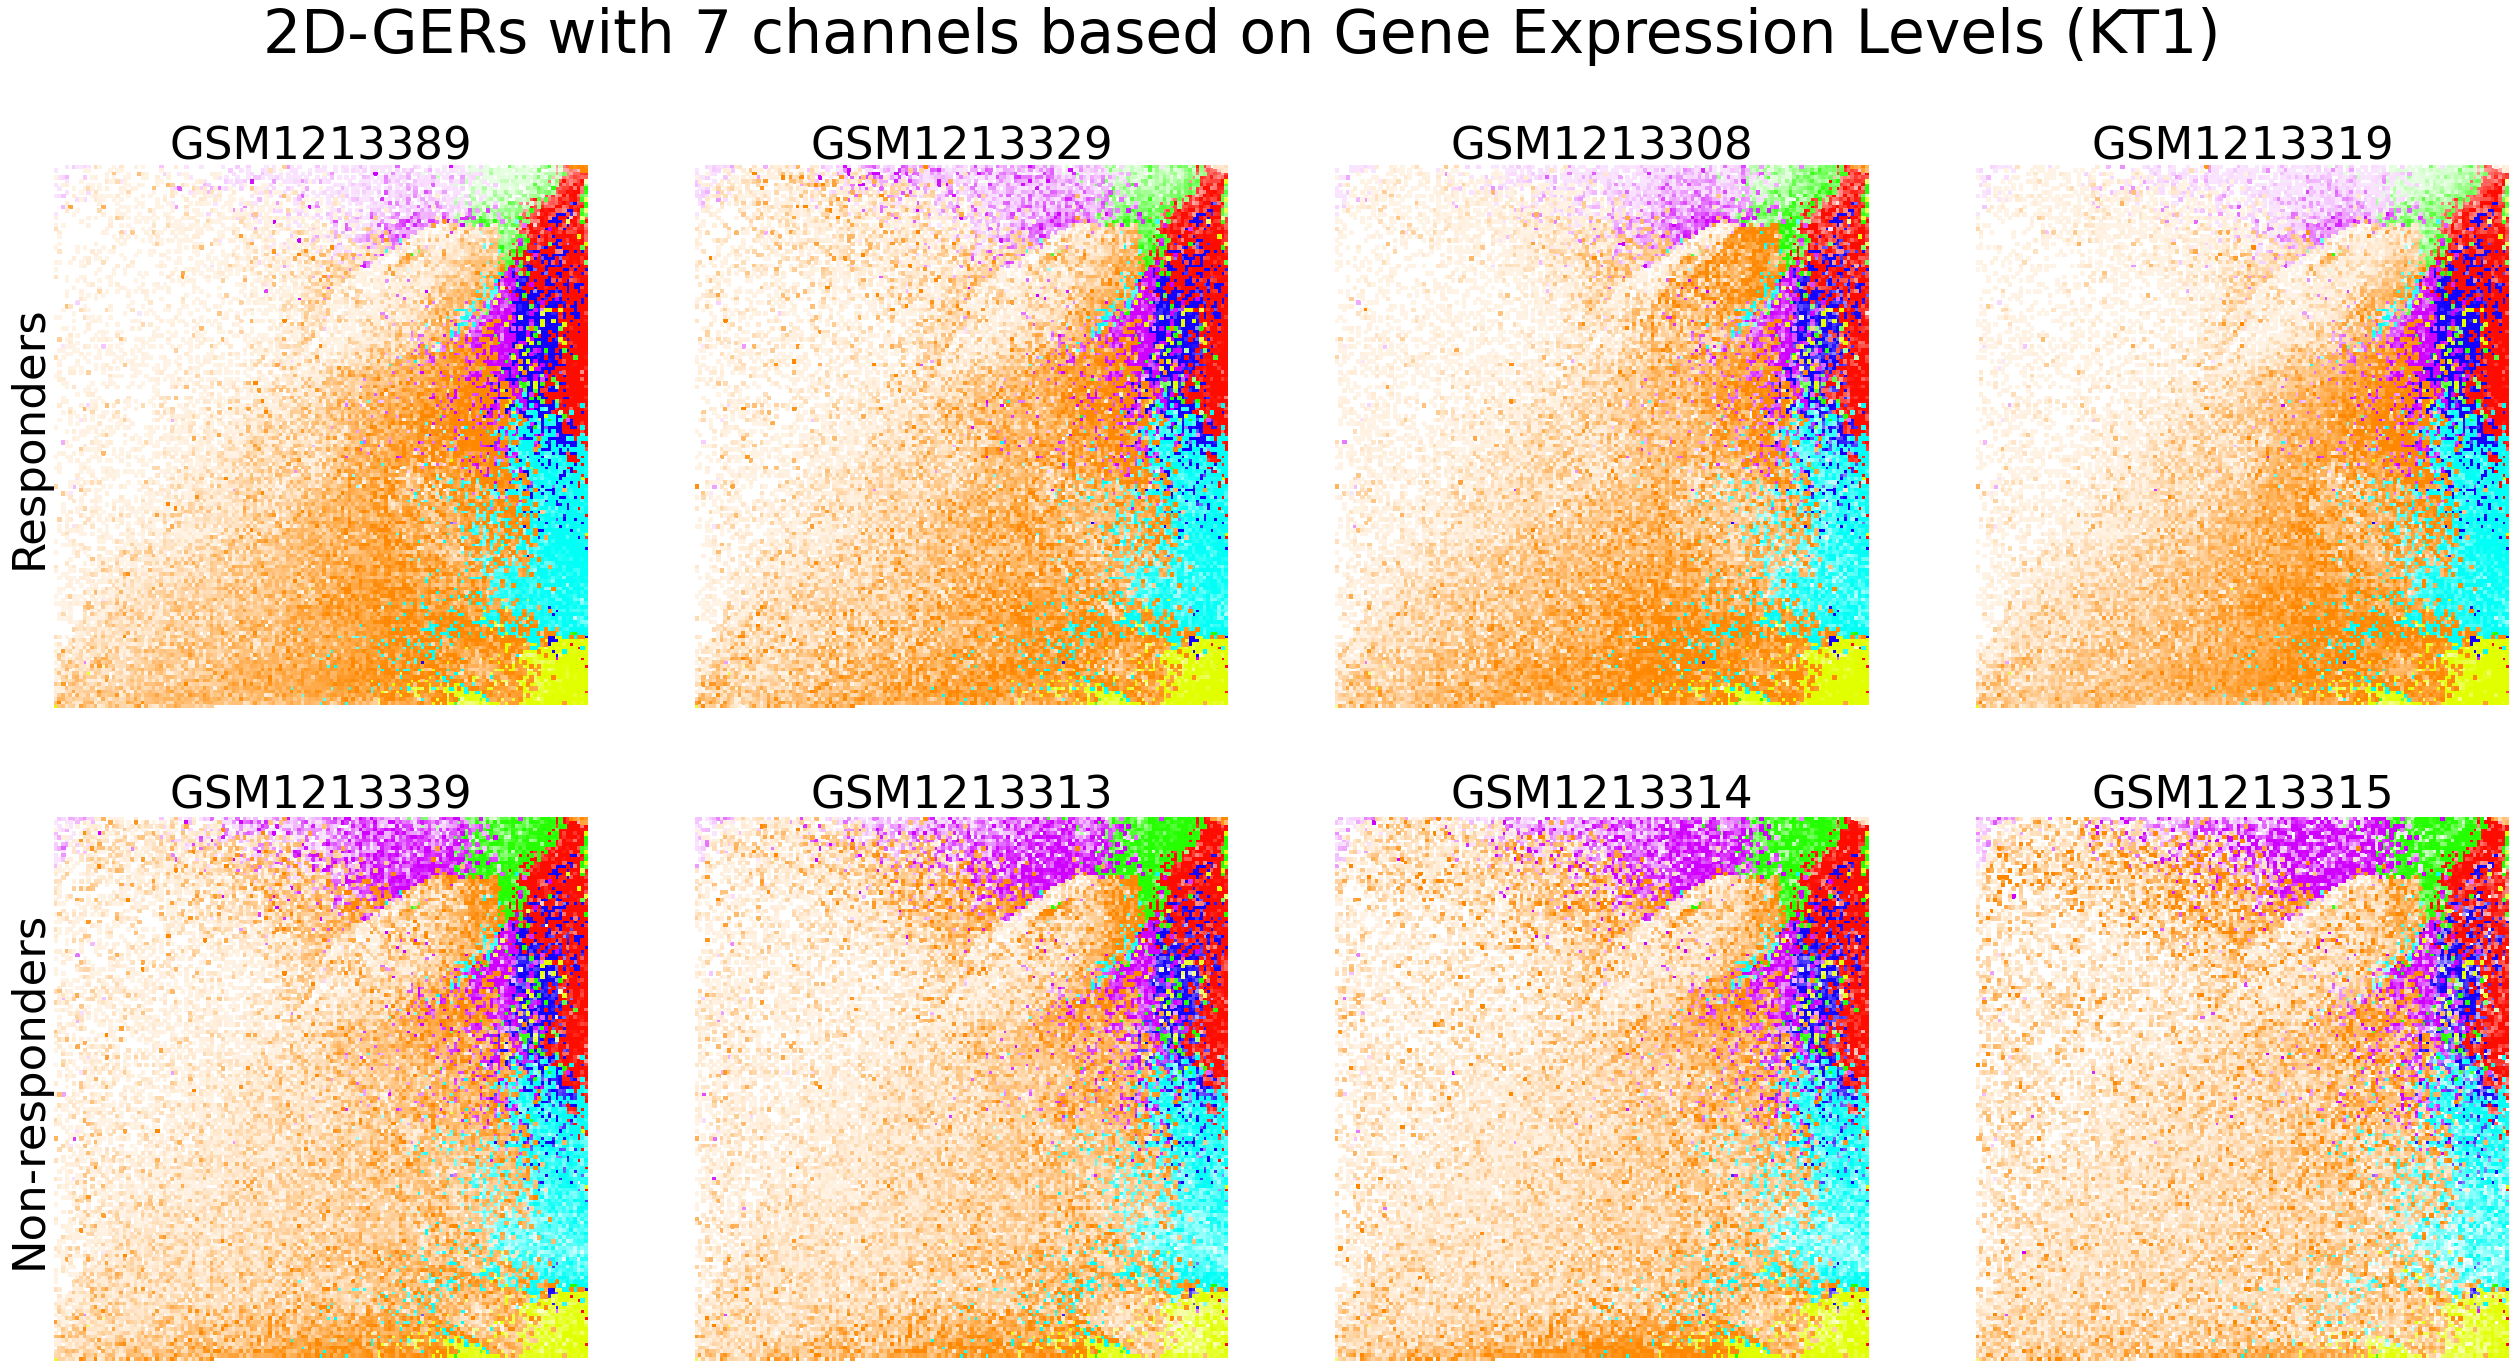

In [39]:
#AggMap output
#figure_mp = new_array.copy()
figure_mp = trainX_mp.copy()
figure_y = trainY.copy()

fv_max = np.percentile(figure_mp.sum(axis = -1), 90)
fv_min = np.percentile(figure_mp.sum(axis = -1), 5)

lb_dic = {0: "-", 1: "+"}

#c_list = ["darkgreen","silver","darkgrey","deeppink","lightblue"]
c_list = ['#1300ff', '#ff0c00', '#25ff00', '#d000ff', '#e2ff00', '#00fff6', '#ff8800', '#fccde5', '#178b66', '#8a0075', \
         '#ff99cc', '#00ccff', '#ff6600', '#339966', '#ccccff', '#008000', "#00ffff", '#00ff00', '#800000', '#cc99ff', \
         '#e1ffff', '#00ced1', '#808000', '#ffa07a', '#f08080', '#ffe4c4', '#ffe4e1', '#ffebcd', '#ffdab9', '#daa520']

ord_mp = np.argsort(figure_y.values)
trvn_list0 = [ord_mp[-1],ord_mp[-2],ord_mp[-3],ord_mp[-4]]
trvn_list1 = [ord_mp[0],ord_mp[1],ord_mp[2],ord_mp[3]]
# trvn_list0 = [-5, 18, -5, 2, 4, 5]
# trvn_list1 = [-1, 7, 9, 0, 1, 3]

fig, axes = plt.subplots(nrows=2, ncols=len(trvn_list0), figsize=(11*len(trvn_list0), 22), sharex = True, sharey = True)

for n,ax in zip(trvn_list0,axes[0]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(figure_y.index[n]),fontsize=45)

for n,ax in zip(trvn_list1,axes[1]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(figure_y.index[n]),fontsize=45)

fig.suptitle("2D-GERs with {} channels based on Gene Expression Levels ({})".format(clu_channels, "KT1"), fontsize=60)
axes[0,0].set_ylabel("Responders",fontsize=45)
axes[1,0].set_ylabel("Non-responders",fontsize=45)

fig.show()
fig.savefig("/raid/mobu/6_figure/{}_final-channels({})_sample.jpg".format("KT1", clu_channels))

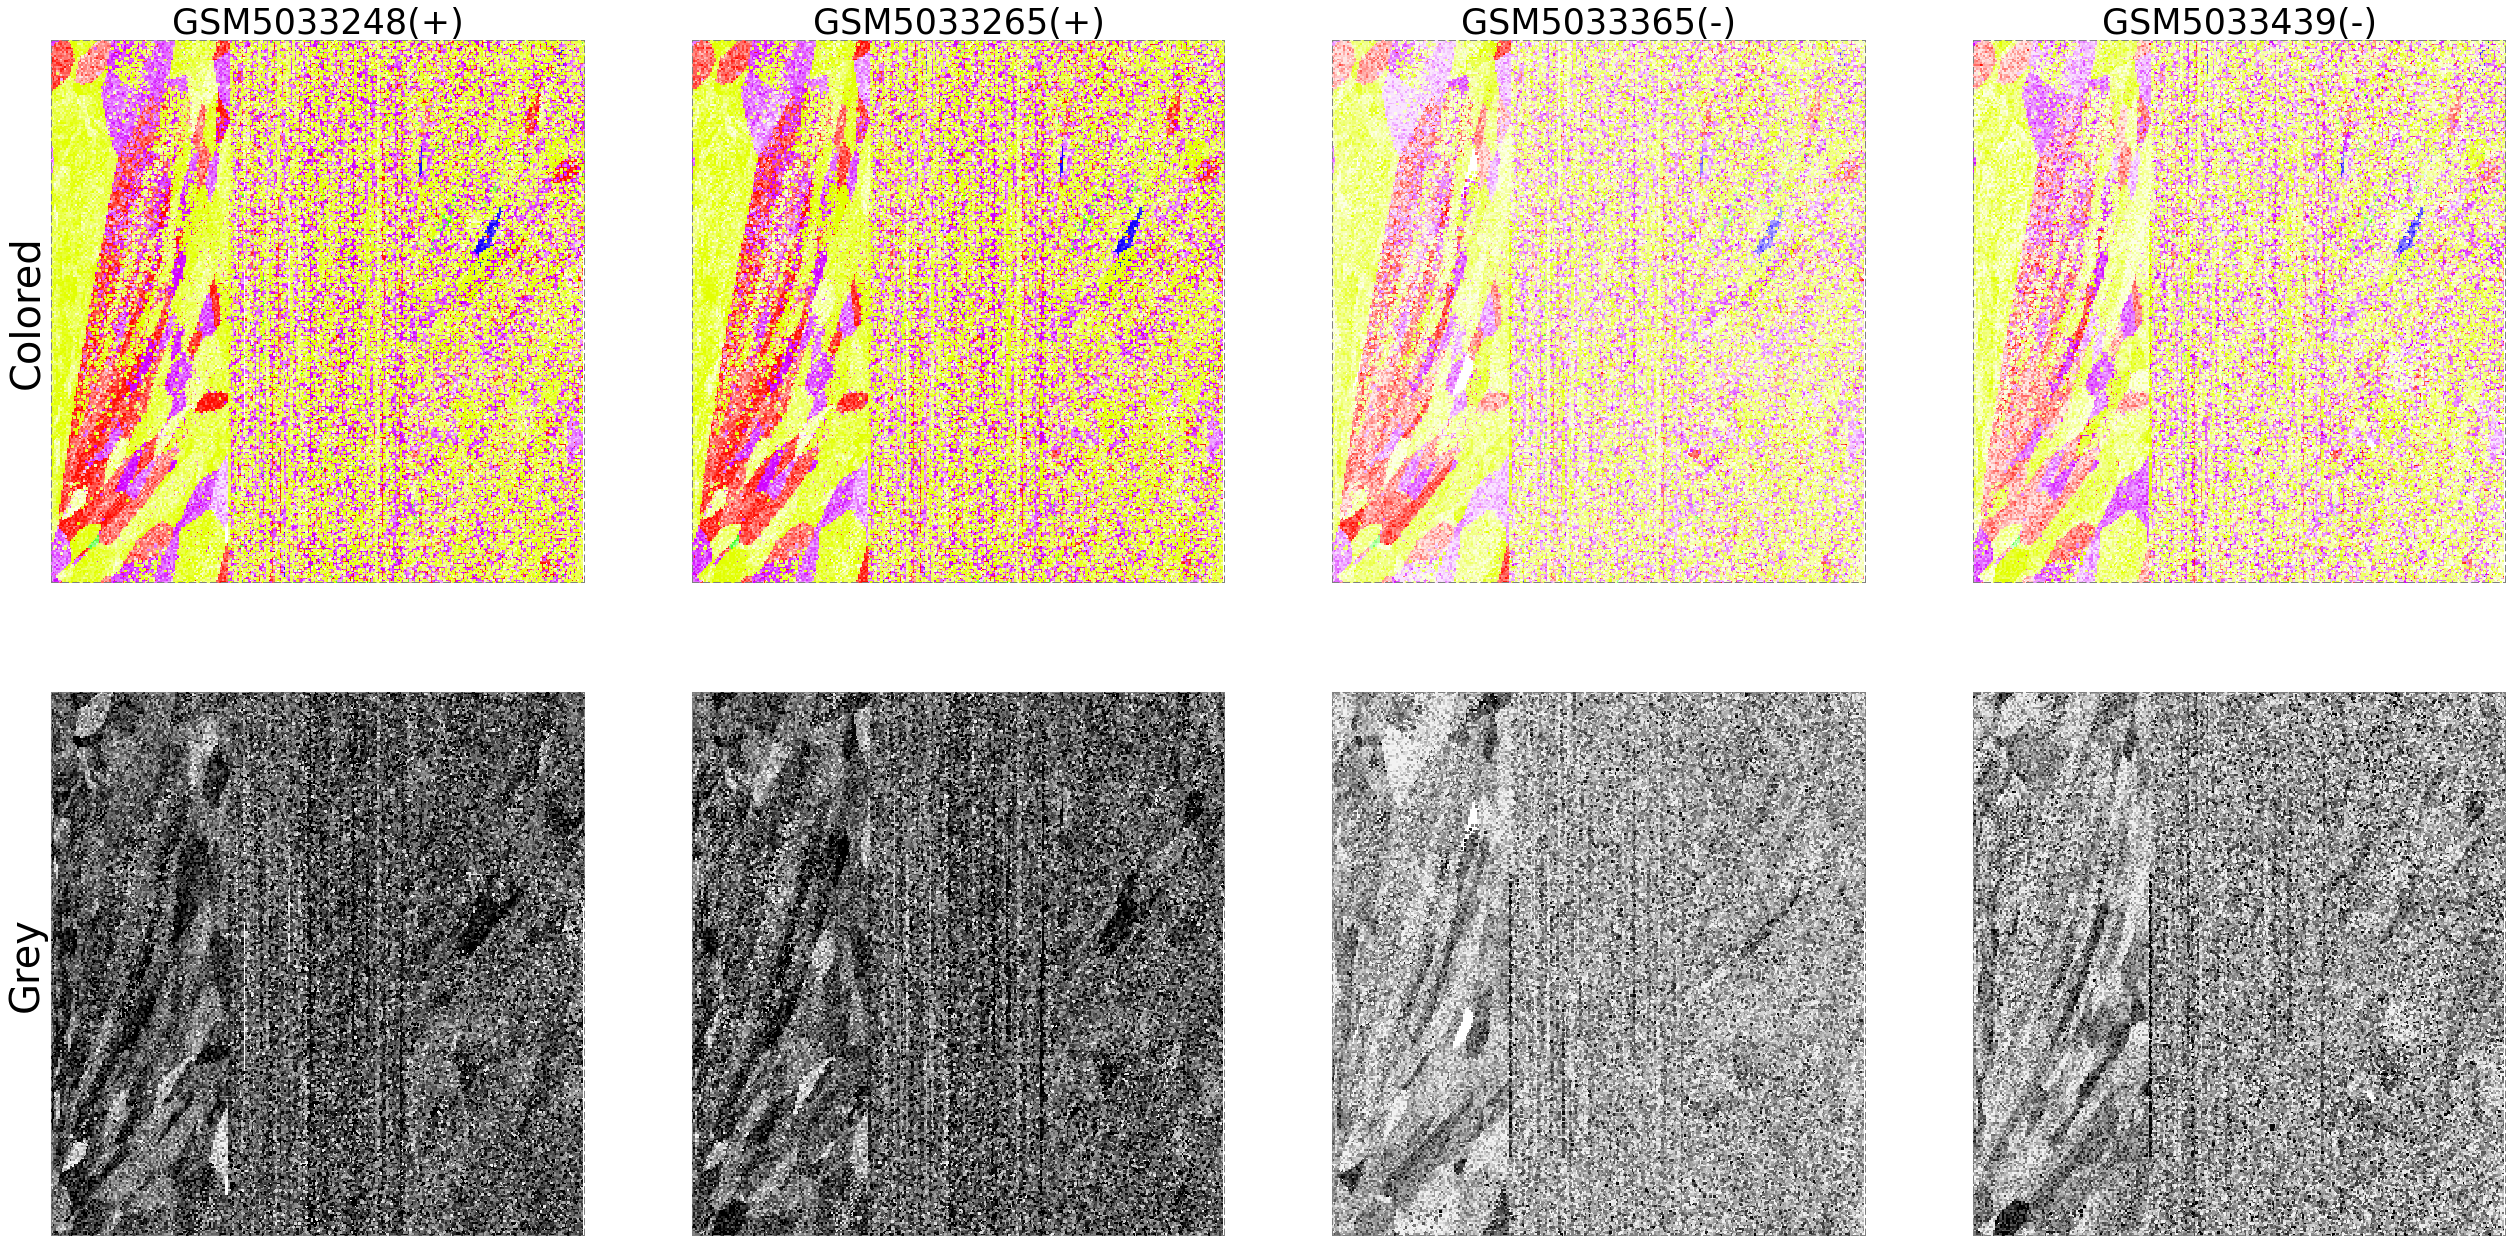

In [28]:
#AggMap output
#figure_mp = new_array.copy()
figure_mp = dataX_mp.copy()
figure_y = dataY.copy()

fv_max = np.nanpercentile(figure_mp.sum(axis = -1), 95)
fv_min = np.nanpercentile(figure_mp.sum(axis = -1), 5)

lb_dic = {0: "-", 1: "+"}

#c_list = ["darkgreen","deeppink","darkgrey","silver","lightblue"] #["darkgreen","silver","darkgrey","deeppink","lightblue"]
c_list = ['#1300ff', '#ff0c00', '#25ff00', '#d000ff', '#e2ff00', '#00fff6', '#ff8800', '#fccde5', '#178b66', '#8a0075', \
         '#ff99cc', '#00ccff', '#ff6600', '#339966', '#ccccff', '#008000', "#00ffff", '#00ff00', '#800000', '#cc99ff', \
         '#e1ffff', '#00ced1', '#808000', '#ffa07a', '#f08080', '#ffe4c4', '#ffe4e1', '#ffebcd', '#ffdab9', '#daa520']

ord_mp = np.argsort(figure_y.values)
trvn_list = [ord_mp[-1],ord_mp[-2],ord_mp[0],ord_mp[1]]

fig, axes = plt.subplots(nrows=2, ncols=len(trvn_list), figsize=(11*len(trvn_list), 22), sharex = True, sharey = True)

for n,ax in zip(trvn_list,axes[0]):
    show.imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}({})".format(figure_y.index[n], lb_dic[figure_y[n]]),fontsize=35)

for n,ax in zip(trvn_list,axes[1]):
    show.imshow(figure_mp[n], ax, mode="white", color_list = ["black"]*clu_channels, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5

#fig.suptitle("AggMap Examples with {} channels based on Gene Expression Levels ({})".format(clu_channels, file), fontsize=50)
axes[0,0].set_ylabel("Colored",fontsize=40)
axes[1,0].set_ylabel("Grey",fontsize=40)

fig.show()
fig.savefig("/raid/mobu/6_figure/{}_channels({})_sample_284X283.jpg".format(file, clu_channels))

In [26]:
mp.fmap_shape

(113, 112)

In [54]:
#Fixed parameters
parameters = {"conv1_kernel_size": 13, "dense_layers": [256],  "epochs": 150, \
              "patience": 30, "batch_size": 128, "lr": 1e-4, "random_state": 32, "verbose": 2}

parameters["gpuid"] = gpu_id

In [55]:
#Model fitting
clf = AggMapNet_DP.MultiClassEstimator(**parameters)
clf.fit(trainX_mp, trainY_binary) #, X_valid = validX_mp, y_valid = validY_binary)

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[256], dropout=0.0,
                    epochs=150, gpuid='3', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=30,
                    random_state=32, verbose=2)
epoch: 0001, loss: 0.6963 - val_loss: 0.6876; accuracy: 0.4945 - val_accuracy: 0.4945                                                                                                    
epoch: 0002, loss: 0.6876 - val_loss: 0.6711; accuracy: 0.5714 - val_accuracy: 0.5714                                                                                                    
epoch: 0003, loss: 0.6711 - val_loss: 0.6594; accuracy: 0.7033 - val_accuracy: 0.7033                                                                                   

epoch: 0043, loss: 0.3625 - val_loss: 0.3550; accuracy: 0.9560 - val_accuracy: 0.9560                                                                                                    
epoch: 0044, loss: 0.3550 - val_loss: 0.3475; accuracy: 0.9560 - val_accuracy: 0.9560                                                                                                    
epoch: 0045, loss: 0.3475 - val_loss: 0.3402; accuracy: 0.9780 - val_accuracy: 0.9780                                                                                                    
epoch: 0046, loss: 0.3402 - val_loss: 0.3328; accuracy: 0.9780 - val_accuracy: 0.9780                                                                                                    
epoch: 0047, loss: 0.3328 - val_loss: 0.3255; accuracy: 0.9780 - val_accuracy: 0.9780                                                                                                    
epoch: 0048, loss: 0.3255 - val_loss: 0.3182; accuracy: 0.9780 - val_a

epoch: 0088, loss: 0.1010 - val_loss: 0.0976; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0089, loss: 0.0976 - val_loss: 0.0944; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0090, loss: 0.0944 - val_loss: 0.0914; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0091, loss: 0.0914 - val_loss: 0.0884; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0092, loss: 0.0884 - val_loss: 0.0855; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0093, loss: 0.0855 - val_loss: 0.0827; accuracy: 1.0000 - val_a

epoch: 0133, loss: 0.0259 - val_loss: 0.0253; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0134, loss: 0.0253 - val_loss: 0.0246; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0135, loss: 0.0246 - val_loss: 0.0240; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0136, loss: 0.0240 - val_loss: 0.0235; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0137, loss: 0.0235 - val_loss: 0.0229; accuracy: 1.0000 - val_accuracy: 1.0000                                                                                                    
epoch: 0138, loss: 0.0229 - val_loss: 0.0224; accuracy: 1.0000 - val_a

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[256], dropout=0.0,
                    epochs=150, gpuid='3', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=30,
                    random_state=32, verbose=2)

In [56]:
#Evaluation
auc = roc_auc_score(testY.values, [i[1] for i in clf.predict_proba(testX_mp)])
acc = accuracy_score(testY.values, clf.predict(testX_mp))
f1 = f1_score(testY.values, clf.predict(testX_mp))
bacc = balanced_accuracy_score(testY.values, clf.predict(testX_mp))

print("F1: {}\nAccuracy: {}\nROC_AUC: {}\nBalanced Accurracy: {}".format(f1, acc, auc, bacc))

F1: 0.6913580246913581
Accuracy: 0.6153846153846154
ROC_AUC: 0.682261208576998
Balanced Accurracy: 0.5906432748538011


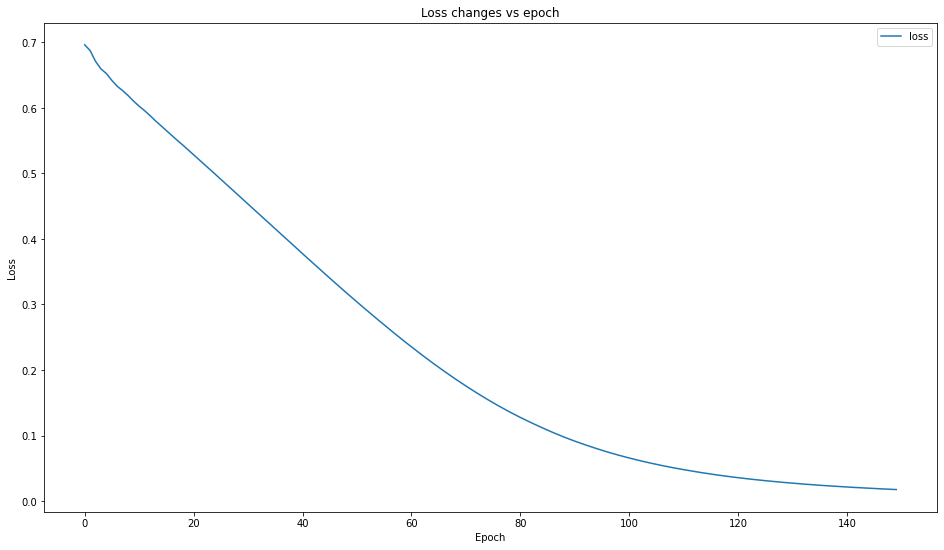

In [57]:
#History records
fig_h, axes_h = plt.subplots(nrows = 1, ncols = 1, figsize=(16, 9), sharex = True, sharey = True)
history_frame = pd.DataFrame(clf.history, columns = ["loss","val_loss"])
epoch = range(len(history_frame))

for i in history_frame.columns[::2]:
    axes_h.plot(epoch, history_frame[i], label = i)
    #axes_h.plot(epoch, np.sqrt(history_frame[i]), label = "{}RMSE".format(i[:-4]))

axes_h.legend(fontsize = 10)
axes_h.set_xlabel('Epoch', fontsize = 10)
axes_h.set_ylabel('Loss', fontsize = 10)
axes_h.set_title("Loss changes vs epoch", fontsize = 12)

fig_h.show()
#fig_h.savefig("/raid/mobu/6_figure/{}_{}mad-pw-history_channels({})_DP.jpg".format(file, f_num, clu_channels))

In [32]:
if file_2:
    file = "{}(train)-{}(test)".format(file, file_2)
clf._model.save("/raid/mobu/3_P_best_model/{}_{}mad-pw_channels({})_{}-cv_best-model_{}_DP".format(file,f_num,clu_channels,cv,ran_seed))
f_tt = open("/raid/mobu/1_DR-{}mad-pw_{}-cv-results_{}_DP.txt".format(f_num,cv,ran_seed), "a+")
f_tt.write("Dataset: {}\nChannels: {}\nBest parameters: {}\nF1: {}\nAccuracy: {}\nROC_AUC: {}\n\n".format(file, clu_channels, parameters, f1, acc, auc))
f_tt.close()

In [29]:
#Performace record
#cv_results.to_csv('/raid/mobu/2_cv-results/{}+{}+{}_{}_channels({})_{}-cv-results_{}.csv'.format(file,drug,data_split,"DR",clu_channels,cv,ran_seed), \
#    na_rep='NA')
clf._model.save("/raid/mobu/3_P_best_model/{}_{}mds-pw_channels({})_{}-cv_best-model_{}_DP".format(file,f_num,clu_channels,cv,ran_seed))
f_tt = open("/raid/mobu/1_DR-{}mds-pw_{}-cv-results_{}_DP.txt".format(f_num,cv,ran_seed), "a+")
f_tt.write("Dataset: {}\nChannels: {}\nBest parameters: {}\nF1: {}\nAccuracy: {}\nROC_AUC: {}\n\n".format(file, clu_channels, parameters, f1, acc, auc))
f_tt.close()

In [10]:
#Model load
file = "Bortezomib+PS341+NR-R_response"
#Bortezomib/Bortezomib_PD-R/Cisplatin/Paclitaxel/CN-AML/MBC/KT-1/KT-2/Docetaxel/Infliximab-1/Infliximab-2
#NPC/BRCA_Cisplatin/PARPI/KT-3/RA-PBMC/RA-CD4/RA-CD14
clu_channels = 5
cv = 5
ran_seed = 0

clf = tf.keras.models.load_model("/raid/mobu/3_P_best_model/{}_DR_channels({})_{}-cv_best-model_{}".format(file,clu_channels,cv,ran_seed))

clf.X_ = trainX_mp
clf.y_ = trainY_binary
clf._model = clf

In [11]:
clf._model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 113, 112, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 112, 48) 40608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 112, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 112, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

RecursionError: maximum recursion depth exceeded while calling a Python object

In [24]:
# Model explaination by simply-explainer: global, local
sl = "PR" #PD, MR, PR, CR / 'CR', 'MR', 'NC', 'PD', 'PR'
all_imp = pd.DataFrame()
simp_explainer = AggMapNet.simply_explainer(clf, mp, apply_logrithm = True, apply_smoothing = True)
#global_simp_importance = simp_explainer.local_explain(trainX_mp[[i == "PD" for i in phe_list]], trainY_binary[[i == "PD" for i in phe_list]])
for i,j,k in zip(trainX_mp[[s == sl for s in phe_list]], trainY_binary[[s == sl for s in phe_list]], trainX.index[[s == sl for s in phe_list]]):
    local_simp_importance = simp_explainer.local_explain(i[None,:], j[None,:])
    one_imp = local_simp_importance["simply_importance"]
    one_imp.rename(k, inplace = True)
    all_imp = pd.concat([all_imp, one_imp], axis = 1)

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

  0%|          | 0/12656 [00:00<?, ?it/s]

In [25]:
all_imp#.mean(axis = 1)

GSM246525  GSM246527  GSM246535  GSM246541  GSM246542  \
ITCH          -0.181565  -0.328714  -0.356322  -0.359876  -0.210427   
LOC100127886  -0.147464  -0.485995  -0.476040  -0.498972  -0.259960   
PLEKHA2       -0.059593  -0.374256  -0.302043  -0.456669  -0.263732   
GRIA2         -0.218900  -0.099127  -0.159889  -0.467757  -0.362711   
USP25         -0.242213   0.202771  -0.242125  -0.549125  -0.454285   
...                 ...        ...        ...        ...        ...   
NaN-12651     -0.204624  -0.083467  -0.511795  -0.335828  -0.188980   
NaN-12652     -0.313782  -0.118561  -0.512175  -0.281438  -0.175249   
NaN-12653     -0.444417  -0.118177  -0.500054  -0.218223  -0.185151   
NaN-12654     -0.465072   0.007045  -0.410724  -0.179605  -0.191895   
NaN-12655     -0.404427   0.090679  -0.280721  -0.131428  -0.162549   

              GSM246543  GSM246546  GSM246547  GSM246554  GSM246555  ...  \
ITCH          -0.184937  -0.288582  -0.317171  -0.375920  -0.242168  ...   
LOC100127886  -0.172325  -0.391638  -0.314253  -0.389562  -0.394306  ...   
PLEKHA2        0.001388  -0.320590  -0.055751  -0.147890  -0.434932  ...   
GRIA2         -0.003807  -0.283921  -0.071005   0.031665  -0.446085  ...   
USP25          0.078120  -0.222248  -0.313878   0.019087  -0.238866  ...   
...                 ...        ...        ...        ...        ...  ...   
NaN-12651     -0.391699   0.270590  -0.483109  -0.255582  -0.072474  ...   
NaN-12652     -0.429577   0.144177  -0.500496  -0.281054  -0.149506  ...   
NaN-12653     -0.452004   0.028346  -0.474732  -0.317766  -0.219848  ...   
NaN-12654     -0.399484   0.087978  -0.316215  -0.321084  -0.132818  ...   
NaN-12655     -0.291564   0.147517  -0.146648  -0.298248  -0.027783  ...   

              GSM246640  GSM246643  GSM246644  GSM246645  GSM246646  \
ITCH           0.115442  -0.533732  -0.592169  -0.200404  -0.398149   
LOC100127886   0.366913  -0.586561  -0.753480  -0.295019  -0.266546   
PLEKHA2        0.425005  -0.400478  -0.651575  -0.398486  -0.120895   
GRIA2          0.348306  -0.246421  -0.409279  -0.499876  -0.218863   
USP25          0.485729  -0.234620  -0.164132  -0.391529  -0.069901   
...                 ...        ...        ...        ...        ...   
NaN-12651      0.328780  -0.022068  -0.281644  -0.259456   0.123962   
NaN-12652      0.334553  -0.027312  -0.323884  -0.190013   0.067044   
NaN-12653      0.290856  -0.027625  -0.366523  -0.176559  -0.018960   
NaN-12654      0.142916   0.077455  -0.408586  -0.135299   0.007683   
NaN-12655     -0.034118   0.152017  -0.391285  -0.064032   0.044462   

              GSM246647  GSM246663  GSM246664  GSM246665  GSM246666  
ITCH          -0.439772  -0.451567  -0.197205  -0.477735  -0.196580  
LOC100127886  -0.427333  -0.284566  -0.155487  -0.513585  -0.327898  
PLEKHA2       -0.148880   0.107495  -0.038829  -0.383841  -0.423250  
GRIA2          0.116905   0.236318  -0.058379  -0.330791  -0.240308  
USP25          0.297877   0.201560   0.035093  -0.184607   0.098625  
...                 ...        ...        ...        ...        ...  
NaN-12651     -0.291578  -0.513615  -0.018620  -0.391131  -0.427557  
NaN-12652     -0.313872  -0.414601  -0.128032  -0.451075  -0.378018  
NaN-12653     -0.296239  -0.330348  -0.319610  -0.481593  -0.380090  
NaN-12654     -0.176439  -0.311116  -0.341644  -0.440733  -0.438752  
NaN-12655     -0.067121  -0.246094  -0.162142  -0.357646  -0.336843  

[12656 rows x 33 columns]

In [26]:
all_imp.to_csv(f"./5_feature_importance/{file}-{sl}_simp-importance_channels({clu_channels})_{ran_seed}_ALS.csv")

In [ ]:
simp_explainer = AggMapNet.simply_explainer(clf, mp, apply_logrithm = True, apply_smoothing = True)
global_simp_importance = simp_explainer.global_explain(trainX_mp, trainY_binary)

2022-11-04 16:56:48,706 - INFO - [bidd-aggmap] - calculating feature importance for class 0 ...


  0%|          | 0/21756 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
if file_2:
    file = "{}(train)-{}(test)".format(file, file_2)

In [13]:
global_simp_importance.to_csv(f"./5_feature_importance/{file}_simp-importance_channels({clu_channels})_{ran_seed}_ALS.csv")

In [15]:
#Feature Importance
file = "KT-1(train)-KT-2(test)_simp-importance_channels(7)_0_ALS"

df_imp = pd.read_csv(f"./5_feature_importance/{file}.csv", header = 0, index_col = 0)
df_imp.sort_values("simply_importance_class_1", ascending = False).iloc[:20]

x   y    Subtypes   colors  simply_importance_class_0  \
MPEG1      122  22  cluster_03  #00ff39                   1.421105   
IL10RA     121  22  cluster_07  #ff00cf                   1.413015   
PTPRC      122  23  cluster_06  #7200ff                   1.410024   
EVI2A      121  23  cluster_07  #ff00cf                   1.406134   
SSR4       122  21  cluster_03  #00ff39                   1.405590   
IRF8       123  22  cluster_03  #00ff39                   1.402651   
MS4A6A     121  21  cluster_07  #ff00cf                   1.400985   
TYROBP     119  25  cluster_07  #ff00cf                   1.397190   
CXCL9      119  24  cluster_07  #ff00cf                   1.396668   
RGS18      123  23  cluster_03  #00ff39                   1.394575   
RPL22L1    120  24  cluster_07  #ff00cf                   1.388888   
HLA-F-AS1  120  23  cluster_07  #ff00cf                   1.388526   
CSF2RB     122  24  cluster_03  #00ff39                   1.388154   
HLA-DPA1   118  25  cluster_07  #ff00cf                   1.387123   
CXCL11     121  24  cluster_07  #ff00cf                   1.387075   
NLRC5      118  26  cluster_07  #ff00cf                   1.385943   
GPR183     123  21  cluster_03  #00ff39                   1.385800   
GGTA1P     120  22  cluster_07  #ff00cf                   1.381047   
CXCL10     118  24  cluster_07  #ff00cf                   1.380533   
C11orf73   123  24  cluster_07  #ff00cf                   1.379776   

           simply_importance_class_1  
MPEG1                       1.474394  
IL10RA                      1.465821  
PTPRC                       1.462651  
EVI2A                       1.458529  
SSR4                        1.457952  
IRF8                        1.454838  
MS4A6A                      1.453073  
TYROBP                      1.449051  
CXCL9                       1.448497  
RGS18                       1.446280  
RPL22L1                     1.440253  
HLA-F-AS1                   1.439869  
CSF2RB                      1.439476  
HLA-DPA1                    1.438383  
CXCL11                      1.438332  
NLRC5                       1.437132  
GPR183                      1.436981  
GGTA1P                      1.431944  
CXCL10                      1.431399  
C11orf73                    1.430597

In [16]:
#Value-based channel
df_nd = np.array(df_imp.simply_importance_class_1).reshape(int(np.ceil(np.sqrt(len(df_imp)))),-1,1)
figure_mp = df_nd.copy()

h, w, c = figure_mp.shape
new_array = np.zeros((h, w, 4), dtype = np.float32)
new_mp = figure_mp.sum(axis = -1).reshape(h, w)

l = 0
for i in [30, 75, 90]:
    exec("per_{} = np.percentile(new_mp, {})".format(l,i))
    l += 1

for i in range(h):
    for j in range(w):
        a = new_mp[i,j]
        if a <= per_0:
            new_array[i,j,0] = a
        elif per_0 < a <= per_1:
            new_array[i,j,1] = a
        elif per_1 < a <= per_2:
            new_array[i,j,2] = a
        else:
            new_array[i,j,3] = a

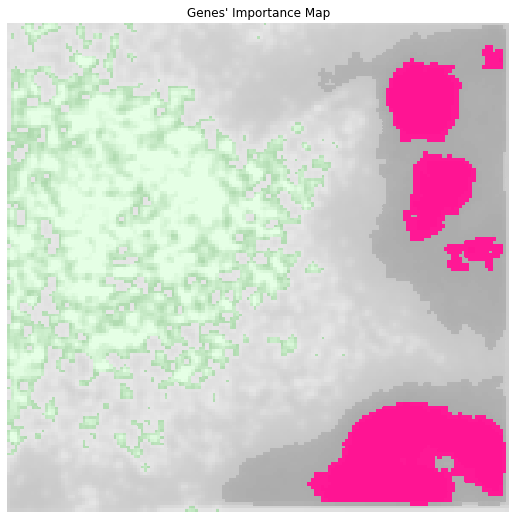

In [17]:
fv_max = np.percentile(new_array.sum(axis = -1), 95)
fv_min = np.percentile(new_array.sum(axis = -1), 5)
c_list = ["darkgreen","silver","darkgrey","deeppink"]

fig_imp, axes_imp = plt.subplots(nrows = 1, ncols = 1, figsize=(9, 9), sharex = True, sharey = True)
imshow(new_array, axes_imp, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max)
axes_imp.set_title("Genes' Importance Map")
fig_imp.show()

In [12]:
fig_imp.savefig("/raid/mobu/6_figure/{}.jpg".format("KT-2_important_map"))

In [25]:
df_imp.sort_values("simply_importance_class_1", ascending = False).to_csv(f"./5_feature_importance/{file}_ranked.csv")

In [20]:
#results ilustration
data_ = pd.read_csv("data_.csv", index_col = None, header = 0)
data_["Improvement"] = data_["CNN-based model"].values - data_["Reference"].values
group_ = []
for i in data_["Reference"]:
    if i < 0.6:
        group_.append("< 0.6")
    elif 0.6 <= i <= 0.8:
        group_.append("0.6 ~ 0.8")
    else:
        group_.append("> 0.8")
data_["Performance of reference"] = group_
data_

CNN-based model  Reference                                 Data group  \
0              0.80       0.75            Response against drug treatment   
1              0.57       0.55            Response against drug treatment   
2              0.69       0.63            Response against drug treatment   
3              0.57       0.54            Response against drug treatment   
4              0.68       0.58            Response against drug treatment   
5              0.51       0.39            Response against drug treatment   
6              0.72       0.63            Response against drug treatment   
7              0.72       0.84            Response against drug treatment   
8              0.65       0.60            Response against drug treatment   
9              0.50       0.46            Response against drug treatment   
10             0.62       0.39            Response against drug treatment   
11             0.75       0.79            Response against drug treatment   
12             0.65       0.59            Response against drug treatment   
13             0.83       0.91            Response against drug treatment   
14             0.75       0.92            Response against drug treatment   
15             0.83       0.81  Relapse / Metastasis after drug treatment   
16             0.71       0.69  Relapse / Metastasis after drug treatment   
17             0.79       0.74                   Response against surgery   
18             0.79       0.74                   Response against surgery   
19             0.82       0.85                   Response against surgery   
20             0.82       0.86                   Response against surgery   

    Improvement Performance of reference  
0          0.05                0.6 ~ 0.8  
1          0.02                    < 0.6  
2          0.06                0.6 ~ 0.8  
3          0.03                    < 0.6  
4          0.10                    < 0.6  
5          0.12                    < 0.6  
6          0.09                0.6 ~ 0.8  
7         -0.12                    > 0.8  
8          0.05                0.6 ~ 0.8  
9          0.04                    < 0.6  
10         0.23                    < 0.6  
11        -0.04                0.6 ~ 0.8  
12         0.06                    < 0.6  
13        -0.08                    > 0.8  
14        -0.17                    > 0.8  
15         0.02                    > 0.8  
16         0.02                0.6 ~ 0.8  
17         0.05                0.6 ~ 0.8  
18         0.05                0.6 ~ 0.8  
19        -0.03                    > 0.8  
20        -0.04                    > 0.8

In [21]:
data_2 = data_.sort_values("Reference", ascending = True)
data_2 = data_2.reset_index(drop = True).copy()
data_2

CNN-based model  Reference                                 Data group  \
0              0.62       0.39            Response against drug treatment   
1              0.51       0.39            Response against drug treatment   
2              0.50       0.46            Response against drug treatment   
3              0.57       0.54            Response against drug treatment   
4              0.57       0.55            Response against drug treatment   
5              0.68       0.58            Response against drug treatment   
6              0.65       0.59            Response against drug treatment   
7              0.65       0.60            Response against drug treatment   
8              0.69       0.63            Response against drug treatment   
9              0.72       0.63            Response against drug treatment   
10             0.71       0.69  Relapse / Metastasis after drug treatment   
11             0.79       0.74                   Response against surgery   
12             0.79       0.74                   Response against surgery   
13             0.80       0.75            Response against drug treatment   
14             0.75       0.79            Response against drug treatment   
15             0.83       0.81  Relapse / Metastasis after drug treatment   
16             0.72       0.84            Response against drug treatment   
17             0.82       0.85                   Response against surgery   
18             0.82       0.86                   Response against surgery   
19             0.83       0.91            Response against drug treatment   
20             0.75       0.92            Response against drug treatment   

    Improvement Performance of reference  
0          0.23                    < 0.6  
1          0.12                    < 0.6  
2          0.04                    < 0.6  
3          0.03                    < 0.6  
4          0.02                    < 0.6  
5          0.10                    < 0.6  
6          0.06                    < 0.6  
7          0.05                0.6 ~ 0.8  
8          0.06                0.6 ~ 0.8  
9          0.09                0.6 ~ 0.8  
10         0.02                0.6 ~ 0.8  
11         0.05                0.6 ~ 0.8  
12         0.05                0.6 ~ 0.8  
13         0.05                0.6 ~ 0.8  
14        -0.04                0.6 ~ 0.8  
15         0.02                    > 0.8  
16        -0.12                    > 0.8  
17        -0.03                    > 0.8  
18        -0.04                    > 0.8  
19        -0.08                    > 0.8  
20        -0.17                    > 0.8

In [22]:
pdic = {}
for i in data_2["Performance of reference"]:
    pdic[i] = data_2.loc[data_2["Performance of reference"]==i, "Improvement"].values
pdic

{'< 0.6': array([0.23, 0.12, 0.04, 0.03, 0.02, 0.1 , 0.06]),
 '0.6 ~ 0.8': array([ 0.05,  0.06,  0.09,  0.02,  0.05,  0.05,  0.05, -0.04]),
 '> 0.8': array([ 0.02, -0.12, -0.03, -0.04, -0.08, -0.17])}

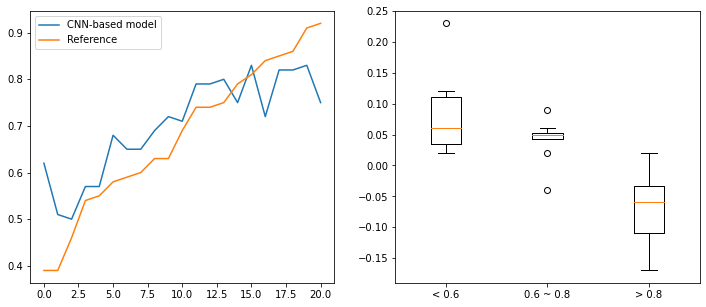

In [36]:
fig_d, ax_d = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5), sharex = False, sharey = False)

ax_d[0].plot(data_2.index.values, data_2["CNN-based model"].values, label = "CNN-based model")
ax_d[0].plot(data_2.index.values, data_2["Reference"].values, label = "Reference")
ax_d[1].boxplot([pdic["< 0.6"], pdic["0.6 ~ 0.8"], pdic["> 0.8"]], labels = ["< 0.6", "0.6 ~ 0.8", "> 0.8"])
ax_d[0].legend()
fig_d.show()

In [38]:
fig_d.savefig("/raid/mobu/6_figure/performance.jpg")

In [29]:
a = pd.DataFrame({"a":[3,4,5,6,7,8,3,2],"b":[2,1,3,2,1,2,4,2],"c":[2,2,1,7,8,9,3,2],"d":[3,2,0,3,1,2,3,5]}, index=["n","v","m","q","z","s","p","i"])
a

a  b  c  d
n  3  2  2  3
v  4  1  2  2
m  5  3  1  0
q  6  2  7  3
z  7  1  8  1
s  8  2  9  2
p  3  4  3  3
i  2  2  2  5

In [31]:
mp_ = AggMap(a.T, metric = "correlation")

2022-11-11 20:42:31,517 - INFO - [bidd-aggmap] - Calculating distance ...
2022-11-11 20:42:31,517 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 8/8 [00:00<00:00, 365.26it/s]


In [34]:
mp_.fit(cluster_channels = 3)

2022-11-11 21:15:33,750 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
UMAP(metric='precomputed', random_state=32, verbose=2)
Fri Nov 11 21:15:33 2022 Construct fuzzy simplicial set
Fri Nov 11 21:15:33 2022 Finding Nearest Neighbors
Fri Nov 11 21:15:33 2022 Finished Nearest Neighbor Search
Fri Nov 11 21:15:33 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Nov 11 21:15:34 2022 Finished embedding
2022-11-11 21:15:34,992 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-11-11 21:15:35,000 - INFO - [bidd-aggmap] - Finished


In [35]:
mp_.df_grid

x  y      v    Subtypes   colors
0  0  0      p  cluster_01  #84ff00
1  1  0      i  cluster_03  #7200ff
2  2  0      n  cluster_02  #00fff6
3  0  1      m  cluster_01  #84ff00
4  1  1      s  cluster_02  #00fff6
5  2  1      v  cluster_02  #00fff6
6  0  2      z  cluster_02  #00fff6
7  1  2      q  cluster_02  #00fff6
8  2  2  NaN-8         NaN  #000000

In [38]:
mp_.df_embedding

x         y    Subtypes   colors    Channels  idx  indices
n  11.260242  5.389483  cluster_02  #00fff6  cluster_02    0        2
v  10.822396  6.235601  cluster_02  #00fff6  cluster_02    1        5
m   9.298419  5.178341  cluster_01  #84ff00  cluster_01    2        3
q   9.900022  6.776999  cluster_02  #00fff6  cluster_02    3        7
z   9.150199  6.300062  cluster_02  #00fff6  cluster_02    4        6
s   9.870098  5.995115  cluster_02  #00fff6  cluster_02    5        4
p   9.792400  4.631835  cluster_01  #84ff00  cluster_01    6        0
i  10.592464  5.028687  cluster_03  #7200ff  cluster_03    7        1

In [45]:
#Grid Assignment
import umap
import numpy as np
import pandas as pd
from lapjv import lapjv
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.stats import median_abs_deviation
from scipy.cluster.hierarchy import fcluster, linkage

N = 8
size1 = 3
size2 = 3
grid_size = (size1, size2)

grid = np.dstack(np.meshgrid(np.linspace(0, 1, size2), np.linspace(0, 1, size1))).reshape(-1, 2)
grid_map = grid[:N]
cost_matrix = cdist(grid_map, mp_.df_embedding[["x","y"]].values, metric = "sqeuclidean").astype(np.float)
cost_matrix = 100000 * (cost_matrix / cost_matrix.max())
row_asses, col_asses, lap_z = lapjv(cost_matrix)

In [47]:
row_asses

array([6, 7, 0, 2, 5, 1, 4, 3], dtype=int32)

In [42]:
mp.df_grid

x    y          v    Subtypes   colors
0        0    0        GCG  cluster_04  #00fff6
1        1    0      DEFA5  cluster_04  #00fff6
2        2    0      MEP1A  cluster_04  #00fff6
3        3    0         SI  cluster_04  #00fff6
4        4    0      MEP1B  cluster_04  #00fff6
...    ...  ...        ...         ...      ...
21751  142  147  NaN-21751         NaN  #000000
21752  143  147  NaN-21752         NaN  #000000
21753  144  147  NaN-21753         NaN  #000000
21754  145  147  NaN-21754         NaN  #000000
21755  146  147  NaN-21755         NaN  #000000

[21756 rows x 5 columns]